In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('realty.csv', index_col=['date'])
prices.head(10)

DLF.NS  GODREJPROP.NS  OBEROIRLTY.NS  PHOENIXLTD.NS  \
date                                                                  
01-01-2018  256.700012     703.849976     480.200012     633.650024   
02-01-2018  253.899994     703.650024     480.399994     635.200012   
03-01-2018  258.299988     710.750000     479.600006     618.250000   
04-01-2018  257.500000     714.750000     487.450012     580.599976   
05-01-2018  259.950012     725.250000     489.700012     575.099976   
08-01-2018  260.250000     736.950012     493.450012     585.650024   
09-01-2018  269.850006     791.549988     506.700012     602.549988   
10-01-2018  269.350006     826.349976     528.000000     589.500000   
11-01-2018  270.500000     844.599976     555.250000     606.650024   
12-01-2018  268.549988     834.750000     532.700012     595.250000   

            PRESTIGE.NS  BRIGADE.NS  IBREALEST.NS    SOBHA.NS  SUNTECK.NS  
date                                                                       
01-01-2018   315.649994  208.933334    219.199997  606.700012  418.549988  
02-01-2018   321.500000  204.899994    215.500000  589.549988  418.649994  
03-01-2018   321.000000  205.300003    216.000000  603.250000  414.450012  
04-01-2018   338.600006  205.100006    219.250000  610.000000  415.600006  
05-01-2018   335.049988  205.500000    221.250000  605.549988  413.149994  
08-01-2018   332.399994  209.000000    229.250000  599.799988  413.399994  
09-01-2018   333.750000  208.533341    235.850006  606.000000  409.750000  
10-01-2018   334.049988  208.100006    247.100006  604.400024  409.899994  
11-01-2018   345.000000  210.199997    255.649994  605.349976  406.549988  
12-01-2018   337.950012  210.266663    253.600006  592.400024  404.700012

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

DLF.NS  GODREJPROP.NS  OBEROIRLTY.NS  PHOENIXLTD.NS  \
date                                                                  
01-01-2018  256.700012     703.849976     480.200012     633.650024   
02-01-2018  253.899994     703.650024     480.399994     635.200012   
30-12-2020  235.949997    1393.750000     567.950012     763.049988   
31-12-2020  232.850006    1432.150024     583.400024     774.549988   

            PRESTIGE.NS  BRIGADE.NS  IBREALEST.NS    SOBHA.NS  SUNTECK.NS  
date                                                                       
01-01-2018   315.649994  208.933334    219.199997  606.700012  418.549988  
02-01-2018   321.500000  204.899994    215.500000  589.549988  418.649994  
30-12-2020   264.899994  246.100006     79.300003  382.500000  356.049988  
31-12-2020   266.100006  249.100006     82.199997  414.649994  347.950012

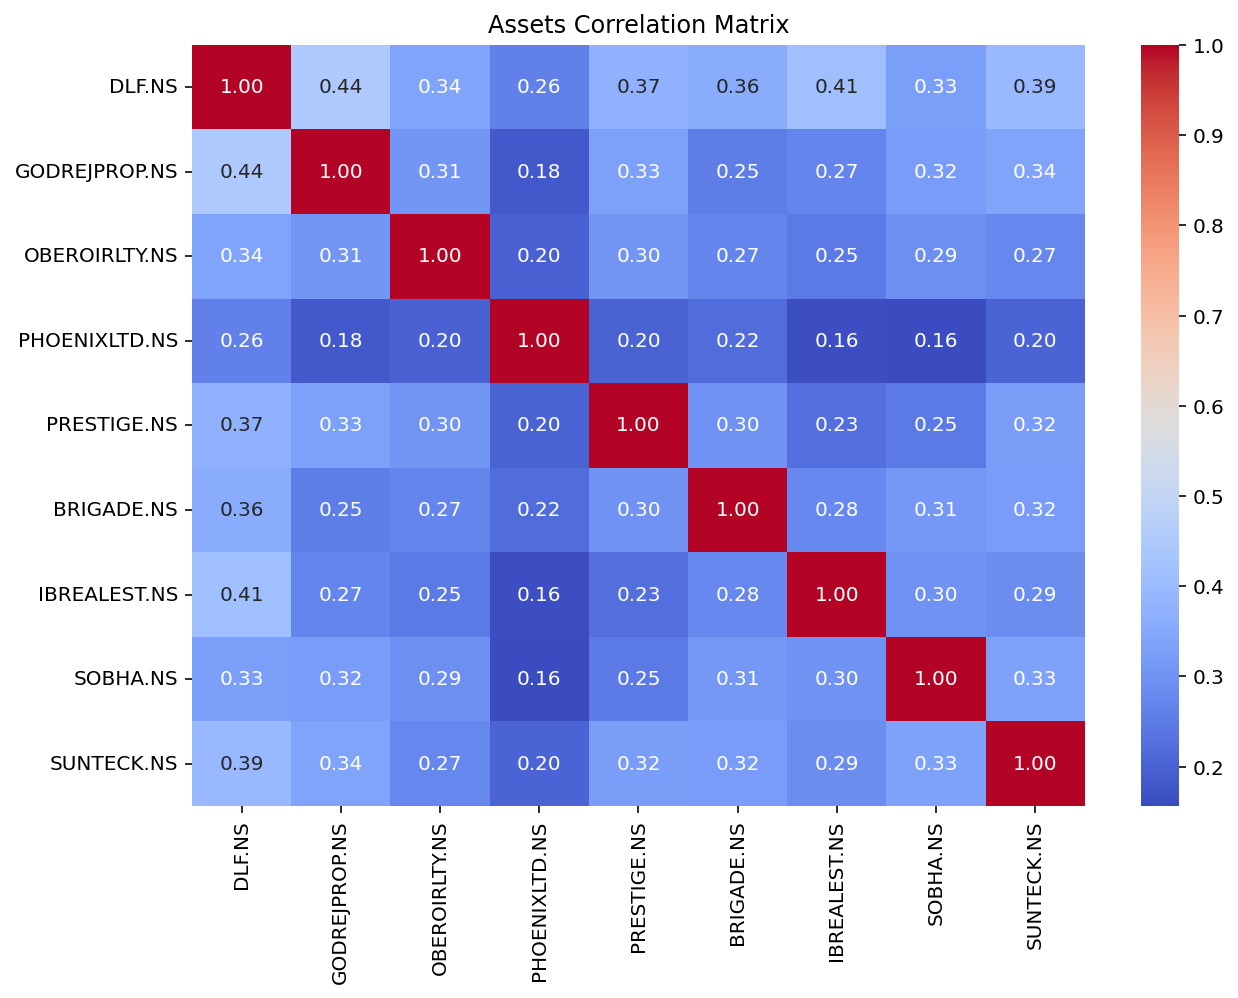

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('DLF.NS', 'OBEROIRLTY.NS'), ('OBEROIRLTY.NS', 'PRESTIGE.NS'), ('OBEROIRLTY.NS', 'SOBHA.NS'), ('OBEROIRLTY.NS', 'SUNTECK.NS'), ('PHOENIXLTD.NS', 'PRESTIGE.NS'), ('PHOENIXLTD.NS', 'BRIGADE.NS')]


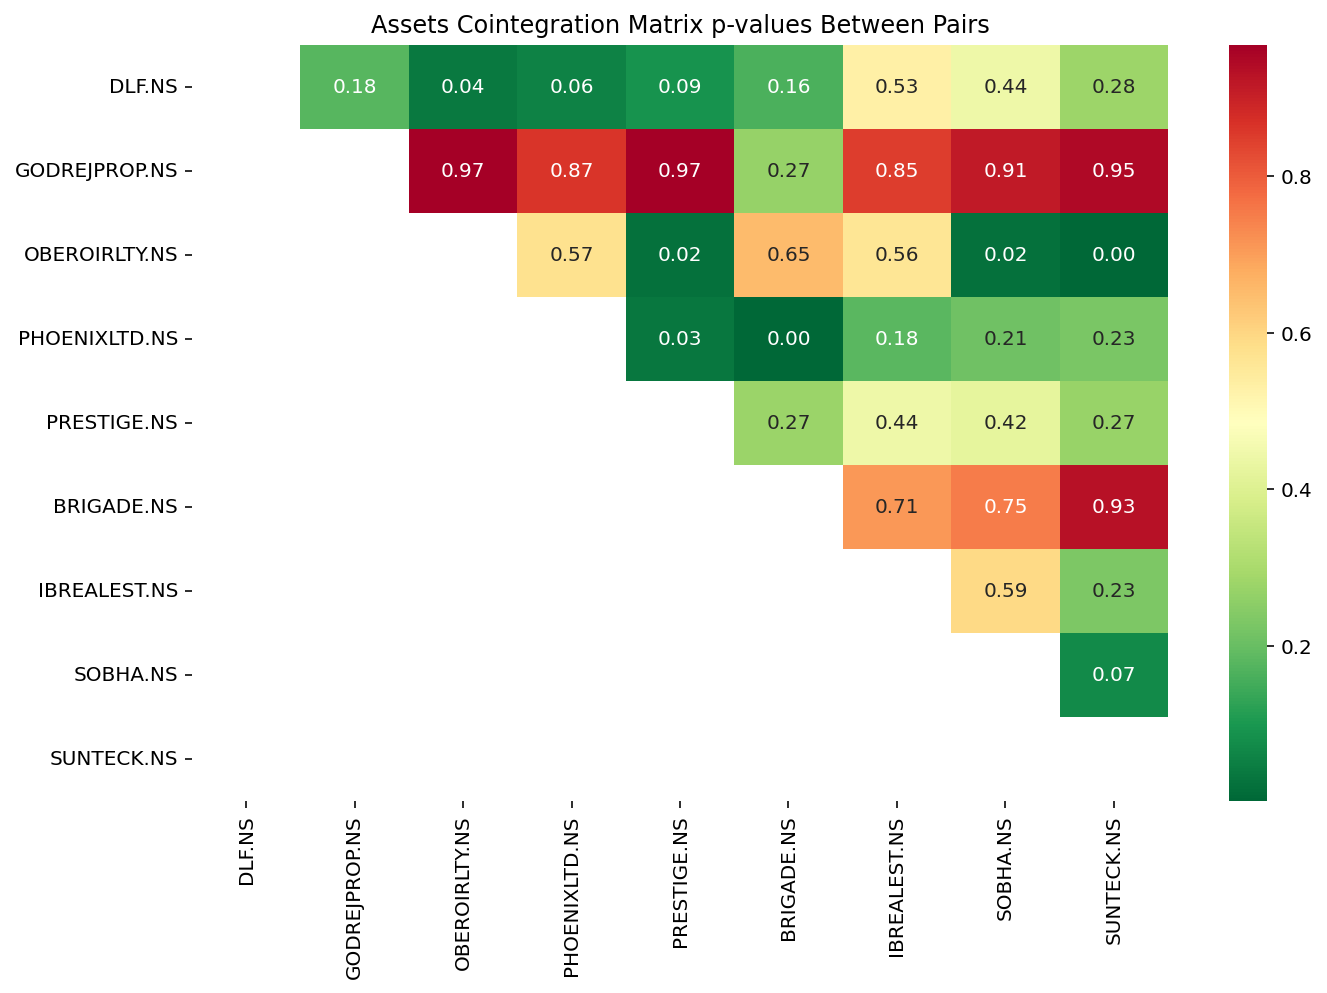

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'DLF.NS'
asset2 = 'OBEROIRLTY.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

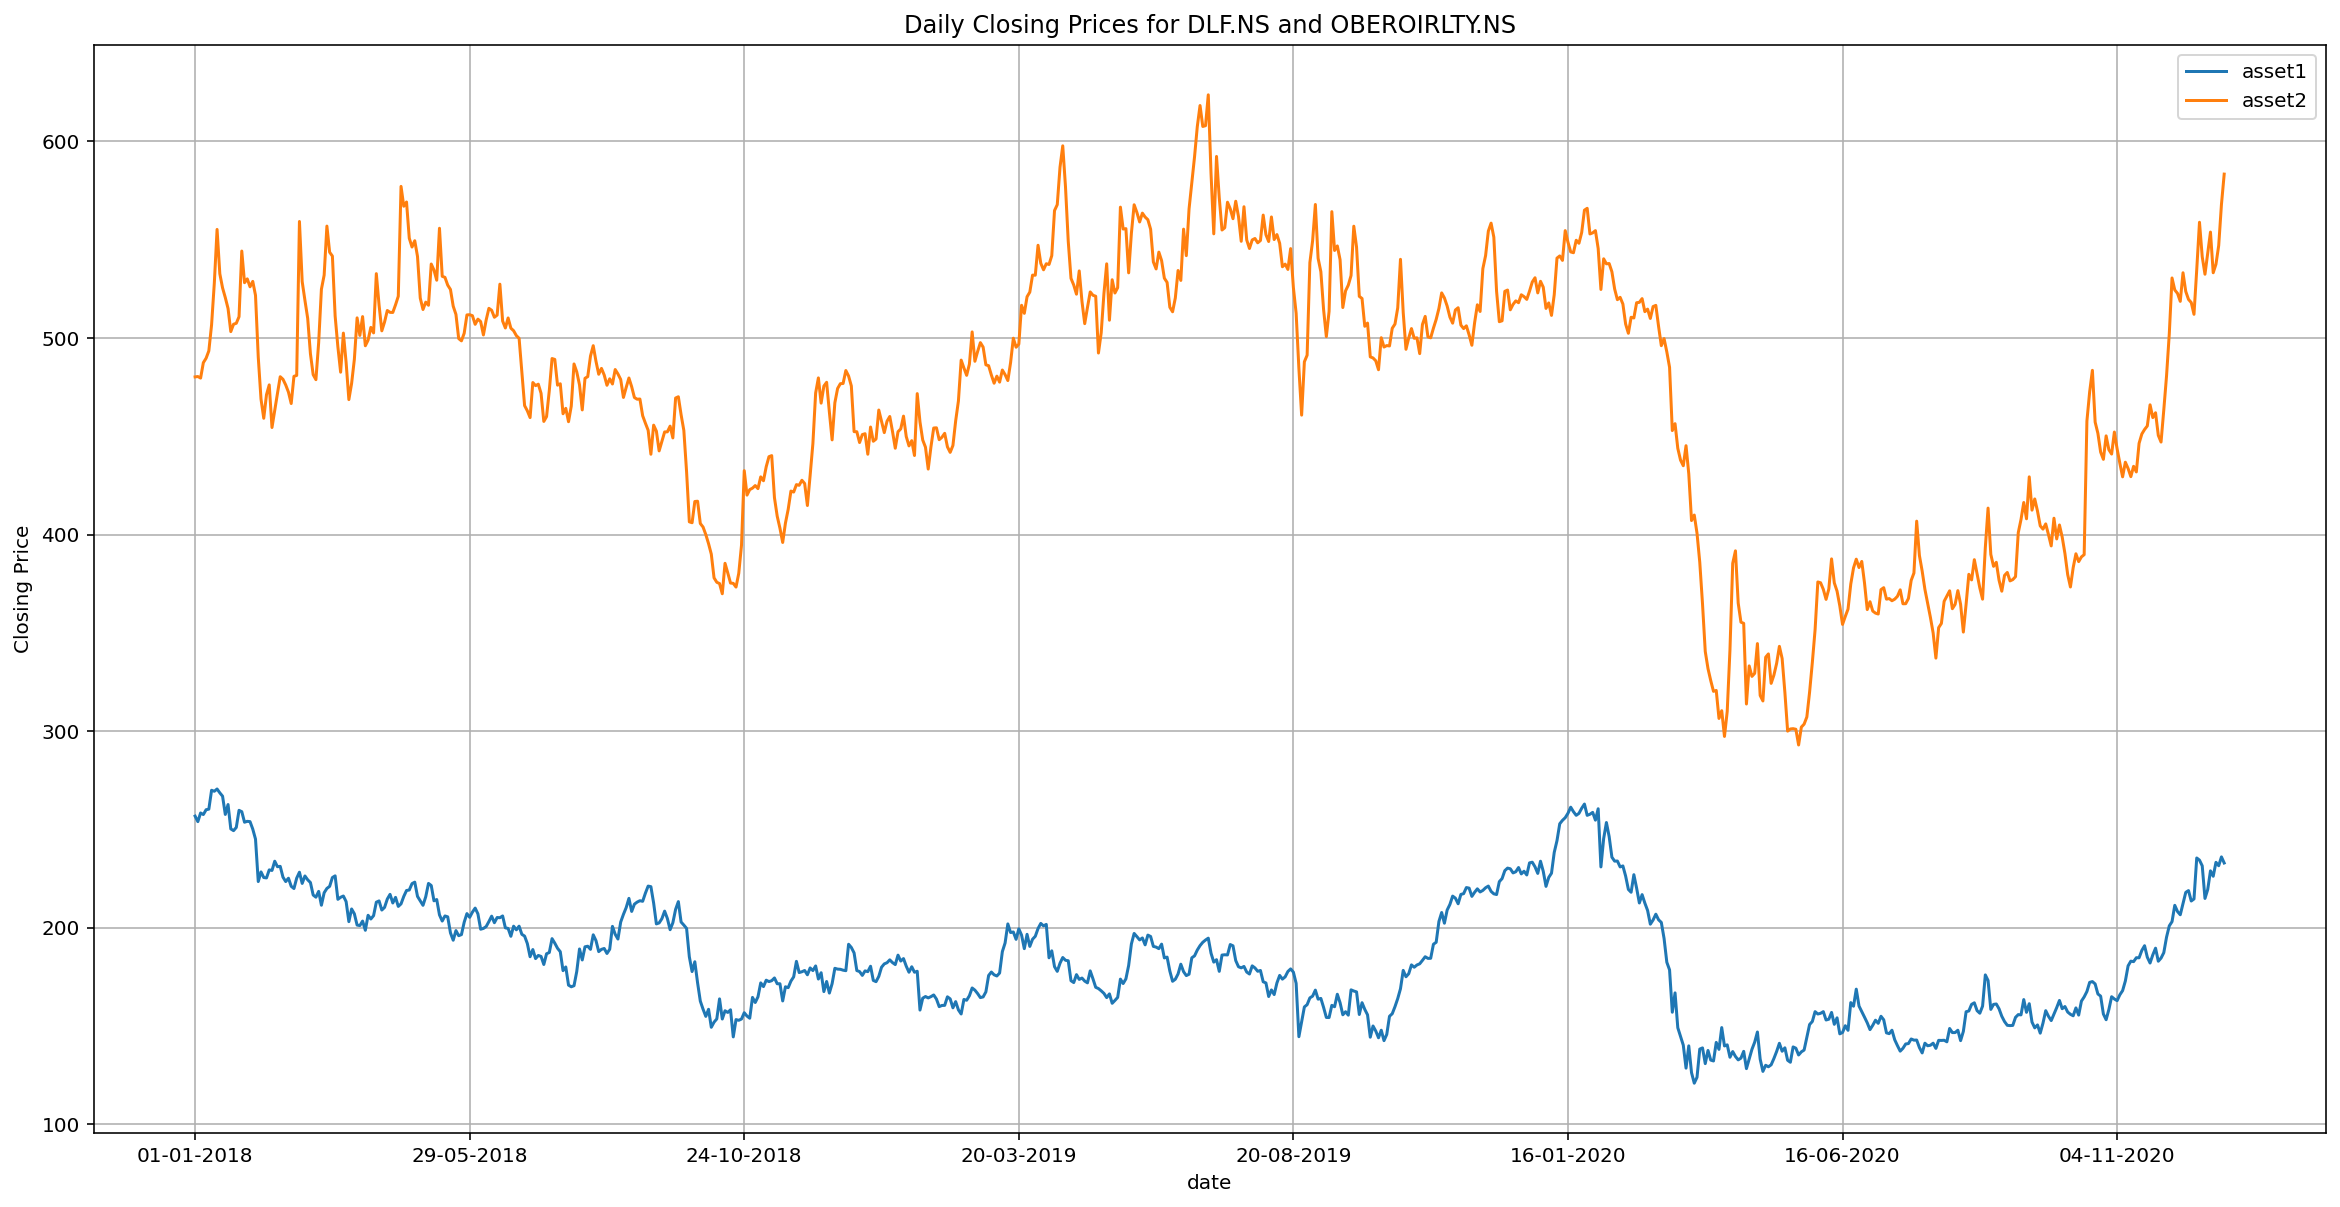

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                          4.211e+04
Date:                Sun, 20 Mar 2022   Prob (F-statistic):                        0.00
Time:                        23:53:53   Log-Likelihood:                         -4112.0
No. Observations:                 740   AIC:                                      8226.
Df Residuals:                     739   BIC:                                      8231.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         2.5144      0.012    205.206      0.000       2.490       2.538
==============================================================================
Omnibus:                        1.382   Durbin-Watson:                   0.058
Prob(Omnibus):                  0.501   Jarque-Bera (JB):                1.297
Skew:                           0.101   Prob(JB):                        0.523
Kurtosis:                       3.034   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  2.5144356721946686


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

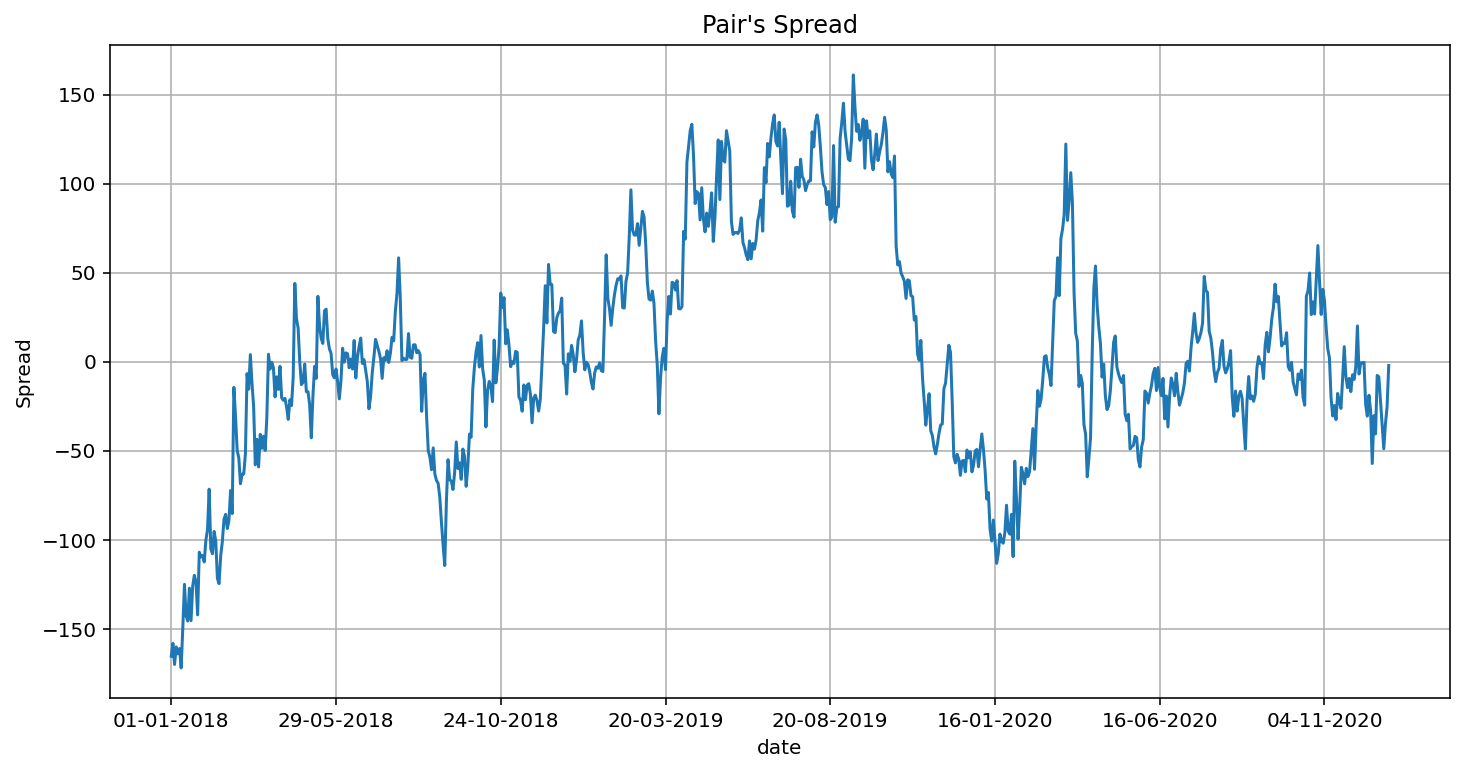

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.6108044625278084,
 0.0055577975847535335,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 6085.895012757092)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.6108044625278084


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                              
01-01-2021  238.350006  590.099976
04-01-2021  244.300003  590.099976
05-01-2021  241.750000  587.250000
06-01-2021  241.050003  587.549988
07-01-2021  245.399994  589.700012

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  238.350006  590.099976 -1.898595            1.0           -1.0
04-01-2021  244.300003  590.099976 -1.620721            1.0           -1.0
05-01-2021  241.750000  587.250000 -1.685018            1.0           -1.0
06-01-2021  241.050003  587.549988 -1.723643            1.0           -1.0
07-01-2021  245.399994  589.700012 -1.561576            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  238.350006  590.099976 -1.898595            1.0           -1.0   
04-01-2021  244.300003  590.099976 -1.620721            1.0           -1.0   
05-01-2021  241.750000  587.250000 -1.685018            1.0           -1.0   
29-12-2021  385.700012  866.250000 -0.759380            1.0           -1.0   
30-12-2021  379.200012  846.650024 -0.686893            1.0           -1.0   
31-12-2021  390.450012  861.799988 -0.544124            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  238.350006  590.099976 -1.898595            1.0           -1.0   
04-01-2021  244.300003  590.099976 -1.620721            1.0           -1.0   
05-01-2021  241.750000  587.250000 -1.685018            1.0           -1.0   
06-01-2021  241.050003  587.549988 -1.723643            1.0           -1.0   
07-01-2021  245.399994  589.700012 -1.561576            1.0           -1.0   
08-01-2021  248.300003  590.500000 -1.441770            1.0           -1.0   
11-01-2021  246.949997  585.549988 -1.407346            1.0           -1.0   
01-02-2021  281.649994  538.849976  1.374611            1.0           -1.0   
02-02-2021  294.500000  546.950012  1.808748            1.0           -1.0   
03-02-2021  289.950012  559.549988  1.250517            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
01-02-2021        -1        -1.0         1         1.0  
02-02-2021        -1         0.0         1         0.0  
03-02-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  238.350006   590.099976 -1.898595            1.0           -1.0   
12-01-2021  267.549988   595.000000 -0.637811            1.0           -1.0   
01-02-2021  281.649994   538.849976  1.374611            1.0           -1.0   
17-03-2021  291.149994   575.200012  0.919468            1.0           -1.0   
08-07-2021  287.850006   664.400024 -1.090207            1.0           -1.0   
08-11-2021  442.200012  1005.400024 -0.908957            1.0           -1.0   
09-11-2021  437.399994  1014.049988 -1.142799            1.0           -1.0   
10-11-2021  434.500000   981.400024 -0.828764            1.0           -1.0   
11-11-2021  416.000000   957.250000 -1.053549            1.0           -1.0   
12-11-2021  428.350006   974.049988 -0.910696            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
12-01-2021         0        -1.0         0         1.0  
01-02-2021        -1        -1.0         1         1.0  
17-03-2021         0         1.0         0        -1.0  
08-07-2021         1         1.0        -1        -1.0  
08-11-2021         0        -1.0         0         1.0  
09-11-2021         1         1.0        -1        -1.0  
10-11-2021         0        -1.0         0         1.0  
11-11-2021         1         1.0        -1        -1.0  
12-11-2021         0        -1.0         0         1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

291.149994    1
287.850006    1
332.850006    1
345.500000    1
417.200012    1
408.850006    1
429.649994    1
437.399994    1
416.000000    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  238.350006  590.099976 -1.898595            1.0           -1.0   
04-01-2021  244.300003  590.099976 -1.620721            1.0           -1.0   
05-01-2021  241.750000  587.250000 -1.685018            1.0           -1.0   
06-01-2021  241.050003  587.549988 -1.723643            1.0           -1.0   
07-01-2021  245.399994  589.700012 -1.561576            1.0           -1.0   
...                ...         ...       ...            ...            ...   
27-12-2021  382.600006  863.750000 -0.822773            1.0           -1.0   
28-12-2021  385.799988  864.750000 -0.734909            1.0           -1.0   
29-12-2021  385.700012  866.250000 -0.759380            1.0           -1.0   
30-12-2021  379.200012  846.650024 -0.686893            1.0           -1.0   
31-12-2021  390.450012  861.799988 -0.544124            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    238.350006           NaN            NaN            NaN       NaN   
1    244.300003      0.000000  100000.000000  100000.000000       NaN   
2    241.750000      0.000000  100000.000000  100000.000000  0.000000   
3    241.050003      0.000000  100000.000000  100000.000000  0.000000   
4    245.399994      0.000000  100000.000000  100000.000000  0.000000   
243  382.600006 -86467.601379  170952.695864   84485.094486 -0.007961   
244  385.799988 -87190.797243  170952.695864   83761.898621 -0.008560   
245  385.700012 -87168.202757  170952.695864   83784.493107  0.000270   
246  379.200012 -85699.202757  170952.695864   85253.493107  0.017533   
247  390.450012 -88241.702757  170952.695864   82710.993107 -0.029823   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1      holdings1          cash1   total asset1   return1  \
0    238.350006            NaN            NaN            NaN       NaN   
7    267.549988  -60466.297243  160466.297243  100000.000000  0.000000   
20   281.649994 -127305.797243  224119.195864   96813.398621 -0.057636   
51   291.149994  -65799.898621  158319.297243   92519.398621  0.068097   
127  287.850006       0.000000   93265.195864   93265.195864  0.017380   

     positions1  
0           NaN  
7          -1.0  
20         -1.0  
51          1.0  
127         1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    238.350006           NaN            NaN            NaN       NaN   
1    244.300003      0.000000  100000.000000  100000.000000       NaN   
2    241.750000      0.000000  100000.000000  100000.000000  0.000000   
3    241.050003      0.000000  100000.000000  100000.000000  0.000000   
4    245.399994      0.000000  100000.000000  100000.000000  0.000000   
243  382.600006 -86467.601379  170952.695864   84485.094486 -0.007961   
244  385.799988 -87190.797243  170952.695864   83761.898621 -0.008560   
245  385.700012 -87168.202757  170952.695864   83784.493107  0.000270   
246  379.200012 -85699.202757  170952.695864   85253.493107  0.017533   
247  390.450012 -88241.702757  170952.695864   82710.993107 -0.029823   

     positions1      asset2     holdings2          cash2   total asset2  \
0           NaN  590.099976           NaN            NaN            NaN   
1           0.0  590.099976      0.000000  100000.000000  100000.000000   
2           0.0  587.250000      0.000000  100000.000000  100000.000000   
3           0.0  587.549988      0.000000  100000.000000  100000.000000   
4           0.0  589.700012      0.000000  100000.000000  100000.000000   
243         0.0  863.750000  82920.000000   61892.804742  144812.804742   
244         0.0  864.750000  83016.000000   61892.804742  144908.804742   
245         0.0  866.250000  83160.000000   61892.804742  145052.804742   
246         0.0  846.650024  81278.402342   61892.804742  143171.207085   
247         0.0  861.799988  82732.798829   61892.804742  144625.603571   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.014323         0.0  
244  0.000663         0.0  
245  0.000994         0.0  
246 -0.012972         0.0  
247  0.010158         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1      holdings1          cash1   total asset1   return1  \
0    238.350006            NaN            NaN            NaN       NaN   
7    267.549988  -60466.297243  160466.297243  100000.000000  0.000000   
20   281.649994 -127305.797243  224119.195864   96813.398621 -0.057636   
51   291.149994  -65799.898621  158319.297243   92519.398621  0.068097   
127  287.850006       0.000000   93265.195864   93265.195864  0.017380   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  590.099976            NaN            NaN            NaN   
7          -1.0  595.000000   57120.000000   42880.000000  100000.000000   
20         -1.0  538.849976  103459.195315   -8849.597658   94609.597658   
51          1.0  575.200012   55219.201171   46369.603514  101588.804685   
127         1.0  664.400024       0.000000  110152.005856  110152.005856   

      return2  positions2  
0         NaN         NaN  
7    0.000000         1.0  
20   0.012222         1.0  
51  -0.021182        -1.0  
127  0.008969        -1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

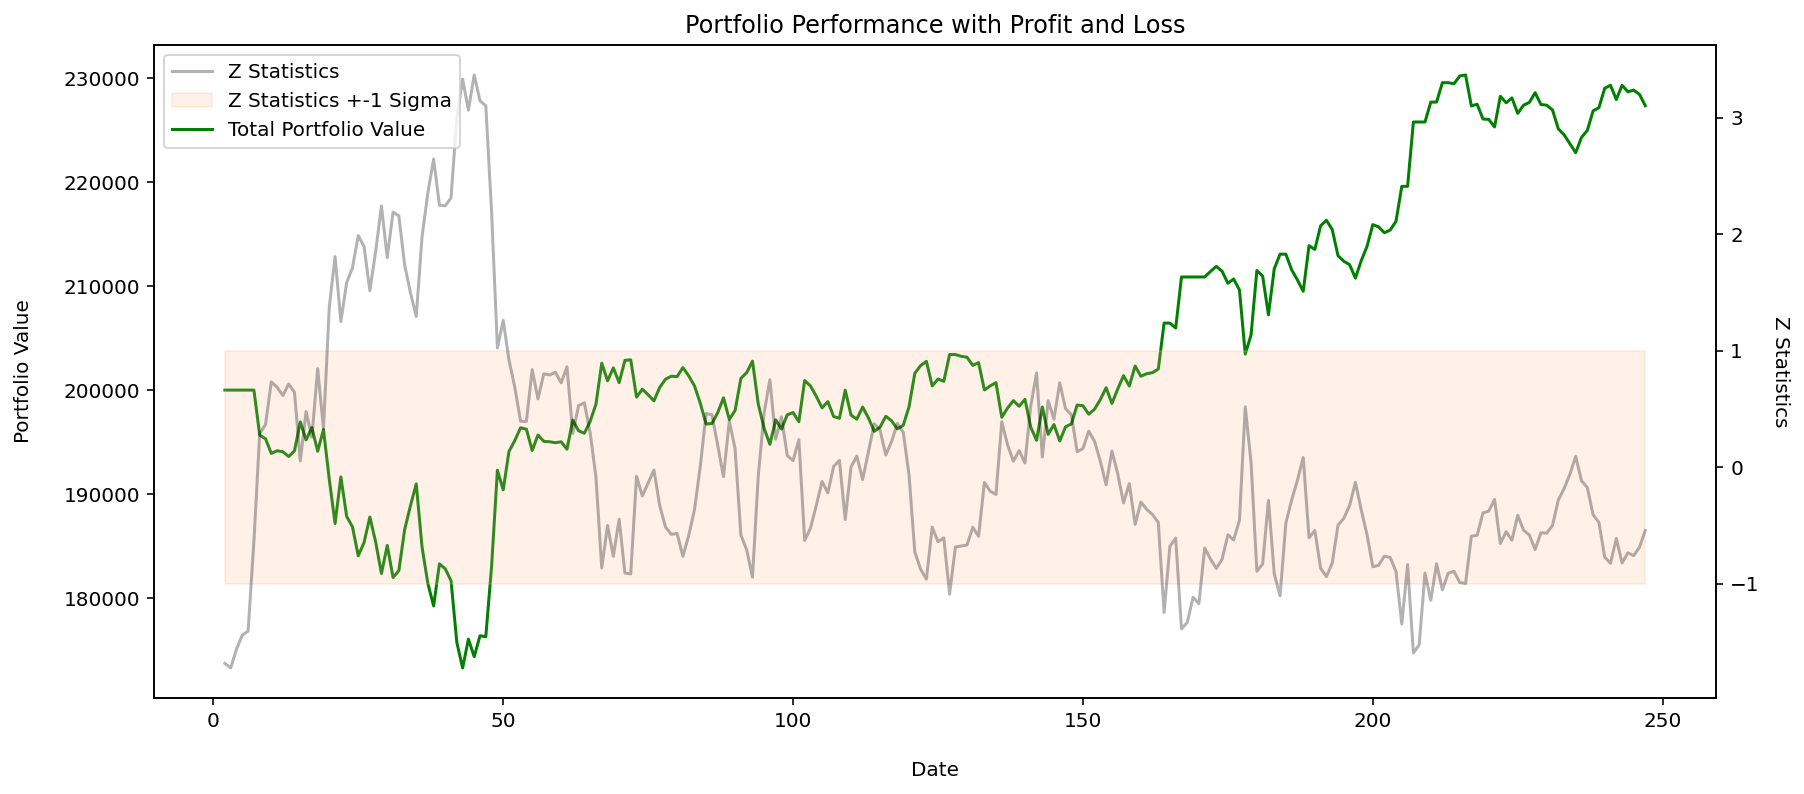

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

227336.5966782

In [48]:
profit = final_portfolio - 2*initial_capital
profit

27336.596678200003

In [49]:
roi = (profit/(2*initial_capital))*100
roi

13.668298339100001

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 239.910%
